In [1]:
import os
import torch
from copy import deepcopy
import numpy as np
import xarray as xr
import pandas as pd
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from sklearn import preprocessing
import zipfile
import shutil
from sklearn.preprocessing import StandardScaler
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
device

'cuda'

In [2]:
def set_seed(seed = 427):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)

In [3]:
class EarthDataSet(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['sst'])

    def __getitem__(self, idx):   
        return (self.data['sst'][idx], self.data['t300'][idx], self.data['ua'][idx], self.data['va'][idx]), self.data['label'][idx]

In [4]:
def fit_data(data_list, fit=True):
    a,b,c,d = data_list[0].shape
    all_data = []
    for data in data_list:
        new_data = data.reshape(-1)
        all_data.append(new_data)
    all_data = np.stack(all_data,1)
    print(all_data.shape)
    if fit:
        standardScaler.fit(all_data)
        print("fit train data")
    all_data = standardScaler.transform(all_data)
    res_data = []
    for i in range(all_data.shape[1]):
        data = all_data[:,i].reshape(a,b,c,d)
        res_data.append(data)
    return res_data

In [5]:
def load_data():
    # CMIP data    
    train = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_train.nc')
    label = xr.open_dataset('tcdata/enso_round1_train_20210201/CMIP_label.nc')    
   
    train_sst = train['sst'][:, :12].values  # (4645, 12, 24, 72)
    train_t300 = train['t300'][:, :12].values
    train_ua = train['ua'][:, :12].values
    train_va = train['va'][:, :12].values
    train_label = label['nino'][:, 12:36].values

    train_ua = np.nan_to_num(train_ua) # trans nan to 0
    train_va = np.nan_to_num(train_va)
    train_t300 = np.nan_to_num(train_t300)
    train_sst = np.nan_to_num(train_sst)
    
    data_list = [train_sst,train_t300,train_ua,train_va]
    train_sst,train_t300,train_ua,train_va = fit_data(data_list, fit=True)

    # SODA data    
    train2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_train.nc')
    label2 = xr.open_dataset('tcdata/enso_round1_train_20210201/SODA_label.nc')
    
    train_sst2 = train2['sst'][:, :12].values  # (100, 12, 24, 72)
    train_t3002 = train2['t300'][:, :12].values
    train_ua2 = train2['ua'][:, :12].values
    train_va2 = train2['va'][:, :12].values
    train_label2 = label2['nino'][:, 12:36].values
    
    train_sst2 = np.nan_to_num(train_sst2) # trans nan to 0
    train_t3002 = np.nan_to_num(train_t3002)
    train_ua2 = np.nan_to_num(train_ua2)
    train_va2 = np.nan_to_num(train_va2)
    
    data_list = [train_sst2,train_t3002,train_ua2,train_va2]
    train_sst2,train_t3002,train_ua2,train_va2 = fit_data(data_list, fit=False)

    print('Train samples: {}, Valid samples: {}'.format(len(train_label), len(train_label2)))

    dict_train = {
        'sst':train_sst,
        't300':train_t300,
        'ua':train_ua,
        'va': train_va,
        'label': train_label}
    dict_valid = {
        'sst':train_sst2,
        't300':train_t3002,
        'ua':train_ua2,
        'va': train_va2,
        'label': train_label2}
    train_dataset = EarthDataSet(dict_train)
    valid_dataset = EarthDataSet(dict_valid)
    return train_dataset, valid_dataset

In [6]:
set_seed()
standardScaler = StandardScaler()
train_dataset, valid_dataset = load_data()      
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

(96318720, 4)
fit train data
(2073600, 4)
Train samples: 4645, Valid samples: 100


In [7]:
def coreff(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    c1 = sum((x - x_mean) * (y - y_mean))
    c2 = sum((x - x_mean)**2) * sum((y - y_mean)**2)
    return c1/np.sqrt(c2)

def rmse(preds, y):
    r = np.sqrt(sum((preds - y)**2) / preds.shape[0])
    return r

def eval_score(preds, label):
    acskill_socre = 0
    rmse_score = 0
    a = [1.5]*4 + [2]*7 + [3]*7 + [4]*6
    for i in range(24):
        r = rmse(preds[:, i], label[:, i], ) # T时刻 (100,)
        cor = coreff(preds[:, i], label[:, i], )
    
        rmse_score += r
        acskill_socre += a[i] * np.log(i+1) * cor
    print("acskill_socre:{}, rmse_score:{}".format(2/3*acskill_socre, rmse_score))
    return 2/3 * acskill_socre - rmse_score

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def train(num_epochs):
    best_score = -99
    loss_epoch = []
    
    epoch = -1
    model.eval()
    y_true, y_pred = [], []
    for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
        sst = sst.to(device).float()
        t300 = t300.to(device).float()
        ua = ua.to(device).float()
        va = va.to(device).float()
        label = label.to(device).float()
        preds = model(sst, t300, ua, va)

        y_pred.append(preds)
        y_true.append(label)

    y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
    x_month = np.arange(24)
    score = eval_score(y_true, y_pred)
    print('Epoch: {}, Valid Score: {}\n'.format(epoch+1,score))    
        
    for epoch in range(num_epochs):
        model.train()
        all_loss = []
        for step, ((sst, t300, ua, va), label) in enumerate(train_loader):                
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            optimizer.zero_grad()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)
            loss = loss_fn(preds, label)
            loss.backward()
            optimizer.step()
            all_loss.append(loss.item())
            if step%20 == 0:
                print('Step: {}, Train Loss: {}'.format(step, loss))
        print('Epoch: {}, Train loss: {}'.format(epoch+1, np.mean(all_loss)))
        loss_epoch.append(np.mean(all_loss))

        model.eval()
        y_true, y_pred = [], []
        for step, ((sst, t300, ua, va), label) in enumerate(valid_loader):
            sst = sst.to(device).float()
            t300 = t300.to(device).float()
            ua = ua.to(device).float()
            va = va.to(device).float()
            label = label.to(device).float()
            preds = model(sst, t300, ua, va)

            y_pred.append(preds)
            y_true.append(label)

        y_true = torch.cat(y_true, axis=0).cpu().detach().numpy()
        y_pred = torch.cat(y_pred, axis=0).cpu().detach().numpy()
        x_month = np.arange(24)
        score = eval_score(y_true, y_pred)
        print('Epoch: {}, Valid Score: {}'.format(epoch+1,score))
        
        torch.save(model.state_dict(), './models/basemodel_epoch_{}.pt'.format(epoch+1))
        if score > best_score:
            torch.save(model.state_dict(), './models/basemodel_best.pt')
            print('Model saved successfully')
            best_score = score
            
        # figure
        plt.figure(figsize = (10,5))
        for i in range(24):
            plt.subplot(5,5,i+1)
            plt.plot(x_month, y_true[i],color='red')
            plt.plot(x_month, y_pred[i],color='blue')
        plt.subplot(5,5,25)
        plt.plot(np.arange(len(loss_epoch)),loss_epoch)
        plt.tight_layout()
        plt.show()
        

In [16]:
class CNN_Model(nn.Module):
    def __init__(self, embed_dim=128):
        super(CNN_Model, self).__init__()
#         self.block = nn.Sequential(nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#                                    nn.Conv2d(64, 128, kernel_size=(2, 4), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
#                                    nn.Conv2d(128, 256, kernel_size=(2, 4), stride=(1, 1), bias=False),
#                                    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
#                                    nn.ReLU(inplace=True),
#                                    nn.AdaptiveAvgPool2d((1, 1)))
        resnet = models.resnet18()
        resnet.conv1 = nn.Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
        resnet.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
#         resnet.fc = nn.Linear(resnet.fc.in_features, 256)
        self.resnet = nn.Sequential(*(list(resnet.children())[:-1]))
        self.lstm = nn.LSTM(input_size = 512, hidden_size = 128, num_layers=2, batch_first=True, bidirectional=True)
        self.avgpool = nn.AvgPool1d(12)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(512, 24)

    def forward(self, sst, t300, ua, va):
        x = torch.cat([sst.unsqueeze(2), t300.unsqueeze(2), ua.unsqueeze(2), va.unsqueeze(2)], dim=2) # b * 12 * 4 * 24 * 72
        seq = []
        for t in range(x.shape[1]):
            t_i = x[:,t,:,:,:] # b * 4 * 24 * 72
            t_i = self.resnet(t_i).squeeze(-1).squeeze(-1) #  # b * 128
#             t_i = torch.flatten(t_i, start_dim=1)
            seq.append(t_i)
        x = torch.stack(seq).transpose(0,1) # b * 12 * 128
#         x, _ = self.lstm(x) # b * 12 * 128
#         x = x[:,-1]
        x = self.avgpool(x.transpose(1,2)).squeeze(-1) # b * 128
        x = self.dropout(x)
        x = self.linear(x)  # b * 24
        return x

In [17]:
model = CNN_Model()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

model = model.to(device)
loss_fn = loss_fn.to(device)

In [18]:
print('{} : all params: {:4f}M'.format(model._get_name(), sum(p.numel() for p in model.parameters()) / 1000 / 1000))

CNN_Model : all params: 12.240280M


In [19]:
model

CNN_Model(
  (resnet): Sequential(
    (0): Conv2d(4, 64, kernel_size=(4, 8), stride=(1, 1), padding=(2, 4), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

acskill_socre:-1.215302469764332, rmse_score:28.263897722479992
Epoch: 0, Valid Score: -29.479200192244324

Step: 0, Train Loss: 0.9349934458732605
Step: 20, Train Loss: 0.6878942847251892
Step: 40, Train Loss: 0.5592431426048279
Step: 60, Train Loss: 0.8334550857543945
Step: 80, Train Loss: 0.4347047805786133
Step: 100, Train Loss: 0.6947734355926514
Step: 120, Train Loss: 0.6046028137207031
Step: 140, Train Loss: 0.533941388130188
Epoch: 1, Train loss: 0.6385054898588625
acskill_socre:14.455977859260766, rmse_score:19.64706653492626
Epoch: 1, Valid Score: -5.191088675665494
Model saved successfully


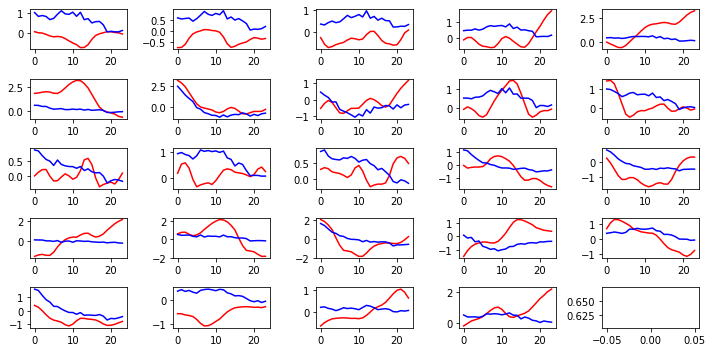

Step: 0, Train Loss: 0.633148729801178
Step: 20, Train Loss: 0.40799233317375183
Step: 40, Train Loss: 0.7838989496231079
Step: 60, Train Loss: 0.4725651741027832
Step: 80, Train Loss: 0.4303494393825531
Step: 100, Train Loss: 0.5672969222068787
Step: 120, Train Loss: 0.4689427316188812
Step: 140, Train Loss: 0.610633909702301
Epoch: 2, Train loss: 0.5156852208996472
acskill_socre:11.833701857616974, rmse_score:19.008030394467994
Epoch: 2, Valid Score: -7.17432853685102


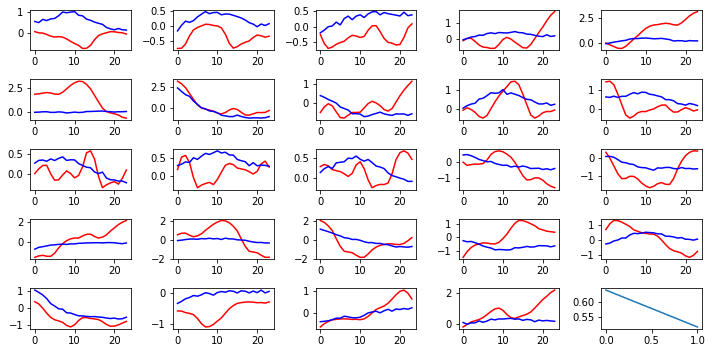

Step: 0, Train Loss: 0.4212801456451416
Step: 20, Train Loss: 0.42582792043685913
Step: 40, Train Loss: 0.6156958341598511
Step: 60, Train Loss: 0.4506208896636963
Step: 80, Train Loss: 0.26133280992507935
Step: 100, Train Loss: 0.3864041268825531
Step: 120, Train Loss: 0.625229001045227
Step: 140, Train Loss: 0.3932795226573944
Epoch: 3, Train loss: 0.39970783613724253
acskill_socre:14.094667076866749, rmse_score:21.942960868714135
Epoch: 3, Valid Score: -7.848293791847386


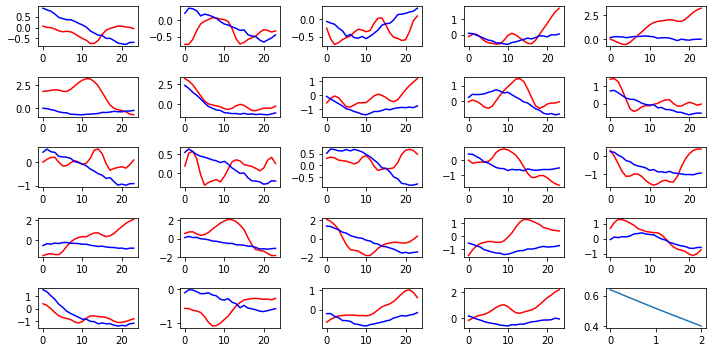

Step: 0, Train Loss: 0.32970869541168213
Step: 20, Train Loss: 0.2635396718978882
Step: 40, Train Loss: 0.27093037962913513
Step: 60, Train Loss: 0.20232319831848145
Step: 80, Train Loss: 0.24722790718078613
Step: 100, Train Loss: 0.23688864707946777
Step: 120, Train Loss: 0.19928030669689178
Step: 140, Train Loss: 0.29627475142478943
Epoch: 4, Train loss: 0.25679897955835684
acskill_socre:12.021927817671349, rmse_score:21.985311886837923
Epoch: 4, Valid Score: -9.963384069166574


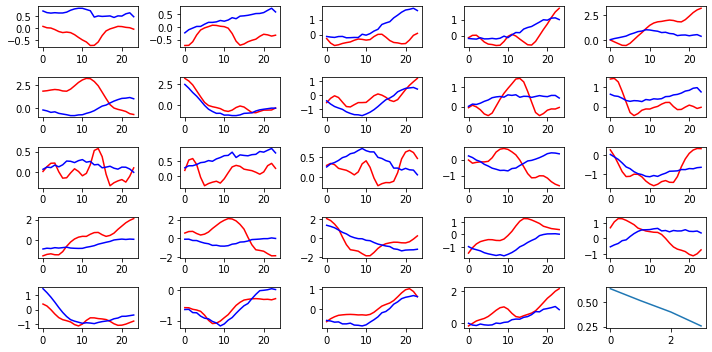

Step: 0, Train Loss: 0.25258105993270874
Step: 20, Train Loss: 0.19078505039215088
Step: 40, Train Loss: 0.15908867120742798
Step: 60, Train Loss: 0.16212543845176697
Step: 80, Train Loss: 0.14579707384109497
Step: 100, Train Loss: 0.17328819632530212
Step: 120, Train Loss: 0.164363294839859
Step: 140, Train Loss: 0.15778449177742004
Epoch: 5, Train loss: 0.17706032357599638
acskill_socre:14.11776314799107, rmse_score:22.93855273887502
Epoch: 5, Valid Score: -8.820789590883951


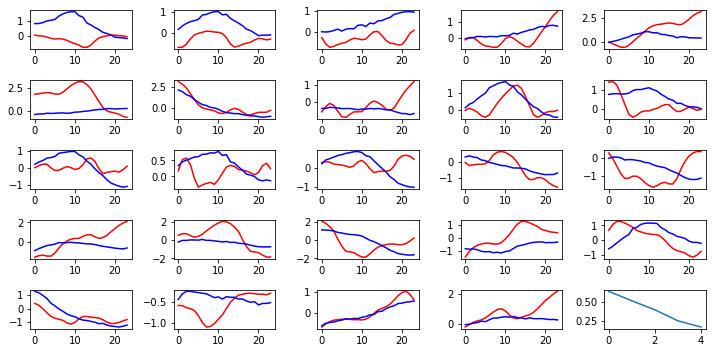

Step: 0, Train Loss: 0.1389566957950592
Step: 20, Train Loss: 0.13984641432762146
Step: 40, Train Loss: 0.1819656789302826
Step: 60, Train Loss: 0.1516348421573639
Step: 80, Train Loss: 0.14066371321678162
Step: 100, Train Loss: 0.1298450231552124
Step: 120, Train Loss: 0.11663146317005157
Step: 140, Train Loss: 0.1433587521314621
Epoch: 6, Train loss: 0.14281920838641793
acskill_socre:16.40584930541167, rmse_score:21.4322183726187
Epoch: 6, Valid Score: -5.026369067207028
Model saved successfully


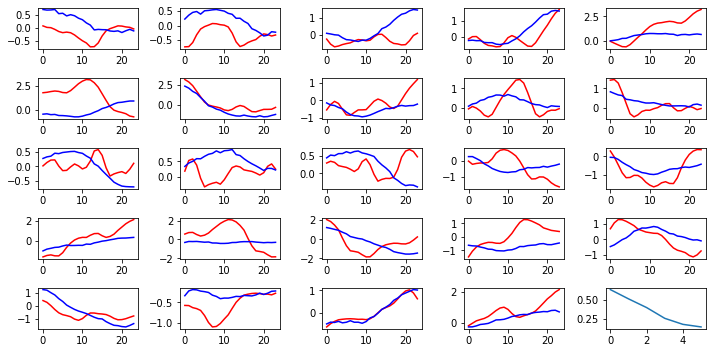

Step: 0, Train Loss: 0.16483087837696075
Step: 20, Train Loss: 0.15556272864341736
Step: 40, Train Loss: 0.1183532327413559
Step: 60, Train Loss: 0.14455200731754303
Step: 80, Train Loss: 0.16274188458919525
Step: 100, Train Loss: 0.08900390565395355
Step: 120, Train Loss: 0.11236114799976349
Step: 140, Train Loss: 0.1111116036772728
Epoch: 7, Train loss: 0.12909067906949617
acskill_socre:14.79619598811774, rmse_score:21.058821869808536
Epoch: 7, Valid Score: -6.262625881690797


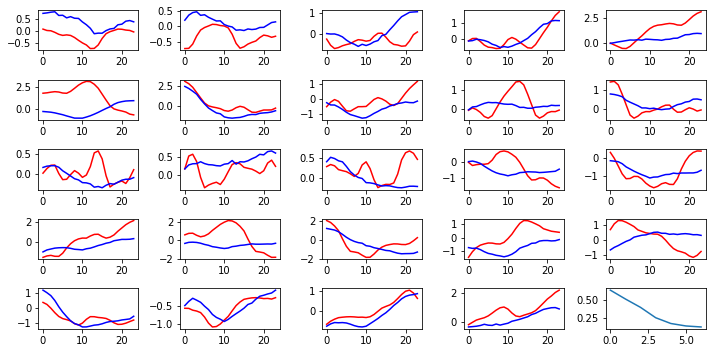

Step: 0, Train Loss: 0.1199718564748764
Step: 20, Train Loss: 0.11272448301315308
Step: 40, Train Loss: 0.11952807754278183
Step: 60, Train Loss: 0.1076202392578125
Step: 80, Train Loss: 0.11583279818296432
Step: 100, Train Loss: 0.08641046285629272
Step: 120, Train Loss: 0.11306403577327728
Step: 140, Train Loss: 0.10737984627485275
Epoch: 8, Train loss: 0.11570811174707869
acskill_socre:16.01431786011871, rmse_score:23.219078968479995
Epoch: 8, Valid Score: -7.204761108361286


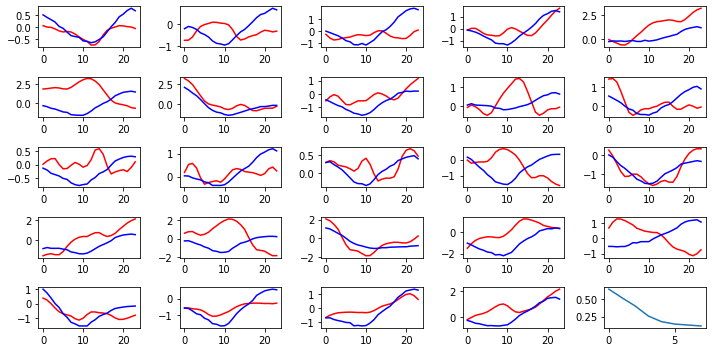

Step: 0, Train Loss: 0.1104079931974411
Step: 20, Train Loss: 0.0982787236571312
Step: 40, Train Loss: 0.10733477771282196
Step: 60, Train Loss: 0.1116943210363388
Step: 80, Train Loss: 0.2370414435863495
Step: 100, Train Loss: 0.17158564925193787
Step: 120, Train Loss: 0.09693257510662079
Step: 140, Train Loss: 0.1143004521727562
Epoch: 9, Train loss: 0.10903848682160247
acskill_socre:15.766607778832503, rmse_score:21.773349591702942
Epoch: 9, Valid Score: -6.006741812870439


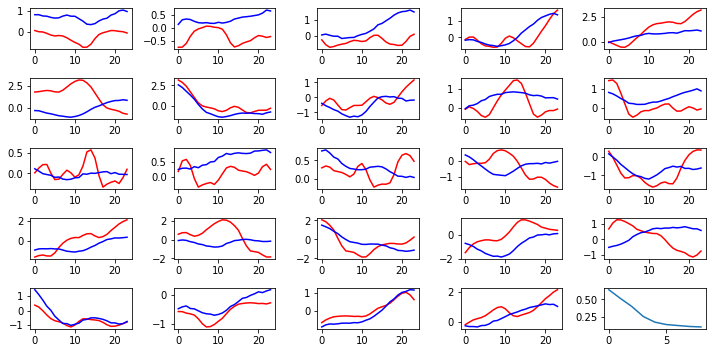

Step: 0, Train Loss: 0.10524506866931915
Step: 20, Train Loss: 0.09558860957622528
Step: 40, Train Loss: 0.0927811712026596
Step: 60, Train Loss: 0.10378416627645493
Step: 80, Train Loss: 0.10709917545318604
Step: 100, Train Loss: 0.07787240296602249
Step: 120, Train Loss: 0.09686445444822311
Step: 140, Train Loss: 0.10600261390209198
Epoch: 10, Train loss: 0.10070312972346397
acskill_socre:17.042407324735258, rmse_score:21.741529692711655
Epoch: 10, Valid Score: -4.699122367976397
Model saved successfully


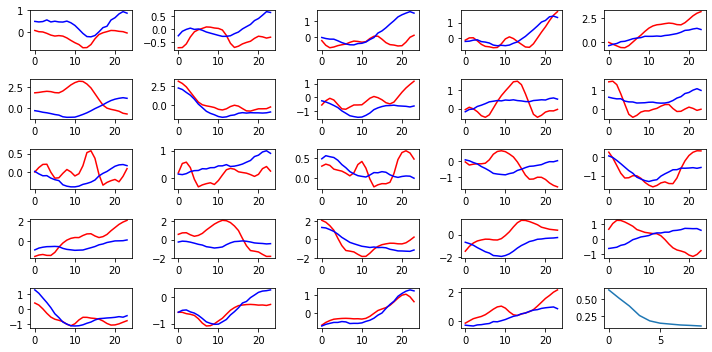

Step: 0, Train Loss: 0.07309802621603012
Step: 20, Train Loss: 0.07395965605974197
Step: 40, Train Loss: 0.07703175395727158
Step: 60, Train Loss: 0.10479366779327393
Step: 80, Train Loss: 0.14338786900043488
Step: 100, Train Loss: 0.11853577941656113
Step: 120, Train Loss: 0.07523685693740845
Step: 140, Train Loss: 0.07549332827329636
Epoch: 11, Train loss: 0.09682676492080297
acskill_socre:16.987711143734114, rmse_score:19.66370810516789
Epoch: 11, Valid Score: -2.675996961433775
Model saved successfully


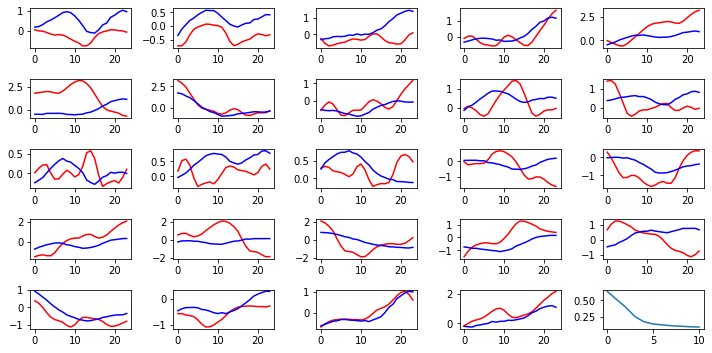

Step: 0, Train Loss: 0.08351629972457886
Step: 20, Train Loss: 0.07549895346164703
Step: 40, Train Loss: 0.2017815113067627
Step: 60, Train Loss: 0.09061311930418015
Step: 80, Train Loss: 0.08481036871671677
Step: 100, Train Loss: 0.10397731512784958
Step: 120, Train Loss: 0.07769447565078735
Step: 140, Train Loss: 0.13557371497154236
Epoch: 12, Train loss: 0.09225952301225433
acskill_socre:17.317057653978136, rmse_score:20.978809814240854
Epoch: 12, Valid Score: -3.6617521602627185


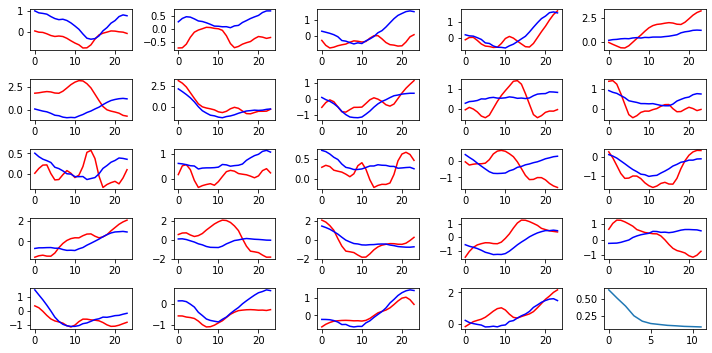

Step: 0, Train Loss: 0.07597366720438004
Step: 20, Train Loss: 0.10014721751213074
Step: 40, Train Loss: 0.08824488520622253
Step: 60, Train Loss: 0.07766455411911011
Step: 80, Train Loss: 0.06432273238897324
Step: 100, Train Loss: 0.07159727066755295
Step: 120, Train Loss: 0.07444825023412704
Step: 140, Train Loss: 0.06285803765058517
Epoch: 13, Train loss: 0.08872253070138905
acskill_socre:16.354296782307202, rmse_score:20.019465525729945
Epoch: 13, Valid Score: -3.6651687434227433


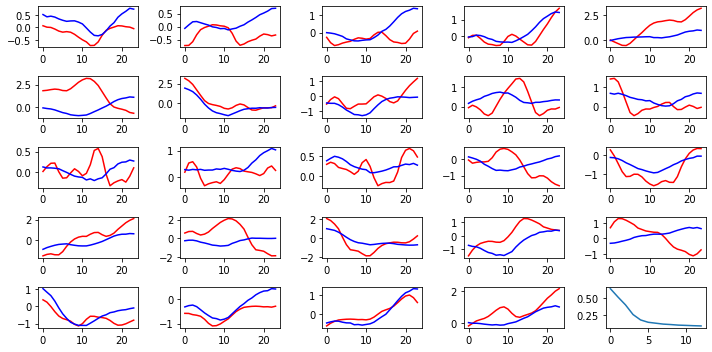

Step: 0, Train Loss: 0.08574604243040085
Step: 20, Train Loss: 0.10115399211645126
Step: 40, Train Loss: 0.06818594038486481
Step: 60, Train Loss: 0.08223584294319153
Step: 80, Train Loss: 0.07498440146446228
Step: 100, Train Loss: 0.06428813934326172
Step: 120, Train Loss: 0.16883116960525513
Step: 140, Train Loss: 0.07061230391263962
Epoch: 14, Train loss: 0.08332241862399938
acskill_socre:16.25332092295458, rmse_score:20.799743369010514
Epoch: 14, Valid Score: -4.546422446055935


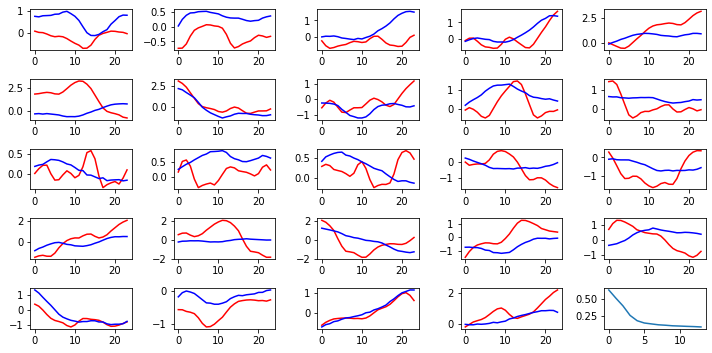

Step: 0, Train Loss: 0.08980575203895569
Step: 20, Train Loss: 0.0989336371421814
Step: 40, Train Loss: 0.06680552661418915
Step: 60, Train Loss: 0.06361132860183716
Step: 80, Train Loss: 0.060656335204839706
Step: 100, Train Loss: 0.06807829439640045
Step: 120, Train Loss: 0.07114261388778687
Step: 140, Train Loss: 0.11771683394908905
Epoch: 15, Train loss: 0.08626019270860985
acskill_socre:14.043947607473648, rmse_score:22.557154272869685
Epoch: 15, Valid Score: -8.513206665396037


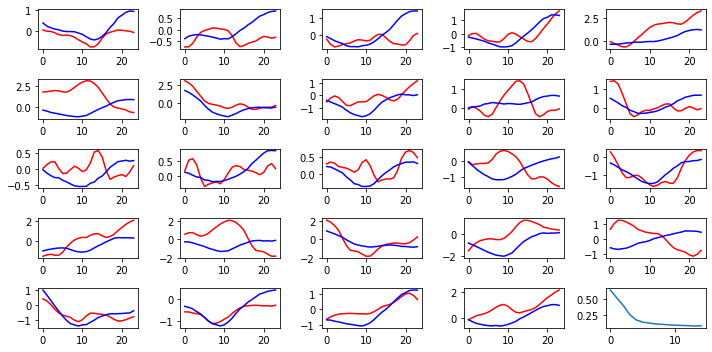

Step: 0, Train Loss: 0.07113420963287354
Step: 20, Train Loss: 0.10289367288351059
Step: 40, Train Loss: 0.07389482110738754
Step: 60, Train Loss: 0.08443604409694672
Step: 80, Train Loss: 0.06361658871173859
Step: 100, Train Loss: 0.07850290834903717
Step: 120, Train Loss: 0.06941628456115723
Step: 140, Train Loss: 0.07832571119070053
Epoch: 16, Train loss: 0.08050385505369265
acskill_socre:17.72532083117009, rmse_score:20.735976581419965
Epoch: 16, Valid Score: -3.0106557502498745


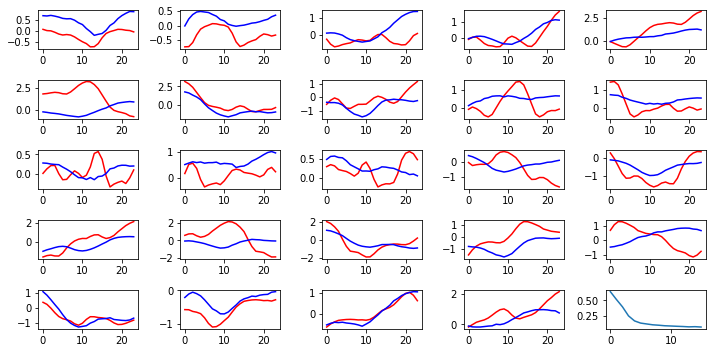

Step: 0, Train Loss: 0.09429746866226196
Step: 20, Train Loss: 0.07270785421133041
Step: 40, Train Loss: 0.09062665700912476
Step: 60, Train Loss: 0.060303788632154465
Step: 80, Train Loss: 0.05634763091802597
Step: 100, Train Loss: 0.08931174874305725
Step: 120, Train Loss: 0.05298326537013054
Step: 140, Train Loss: 0.0886525958776474
Epoch: 17, Train loss: 0.07951347491614623
acskill_socre:16.85052730900631, rmse_score:22.255355374337608
Epoch: 17, Valid Score: -5.404828065331298


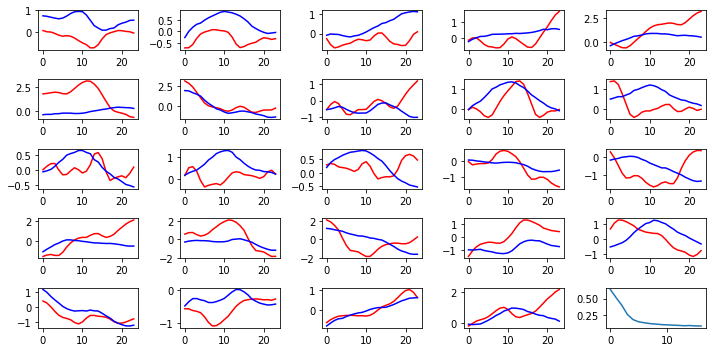

Step: 0, Train Loss: 0.06503140926361084
Step: 20, Train Loss: 0.05454057455062866
Step: 40, Train Loss: 0.058143895119428635
Step: 60, Train Loss: 0.04808233678340912
Step: 80, Train Loss: 0.058780357241630554
Step: 100, Train Loss: 0.07728710770606995
Step: 120, Train Loss: 0.09556349366903305
Step: 140, Train Loss: 0.08966092765331268
Epoch: 18, Train loss: 0.07836208862494932
acskill_socre:16.327776826586447, rmse_score:20.7417873126263
Epoch: 18, Valid Score: -4.414010486039853


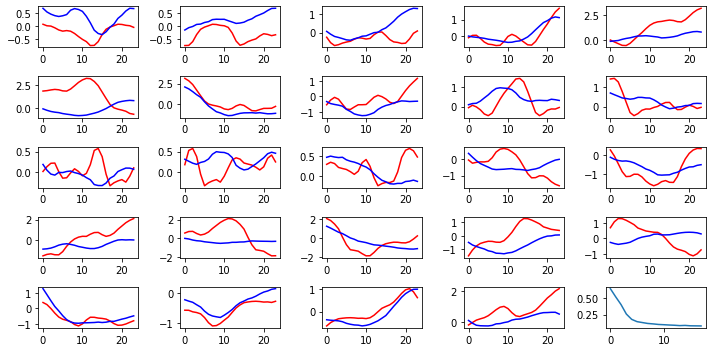

Step: 0, Train Loss: 0.07192232459783554
Step: 20, Train Loss: 0.058027803897857666
Step: 40, Train Loss: 0.06832006573677063
Step: 60, Train Loss: 0.0640949010848999
Step: 80, Train Loss: 0.11824075877666473
Step: 100, Train Loss: 0.05666237324476242
Step: 120, Train Loss: 0.054966624826192856
Step: 140, Train Loss: 0.056778475642204285
Epoch: 19, Train loss: 0.07886472951671848
acskill_socre:17.117763069915796, rmse_score:21.547085353875243
Epoch: 19, Valid Score: -4.429322283959447


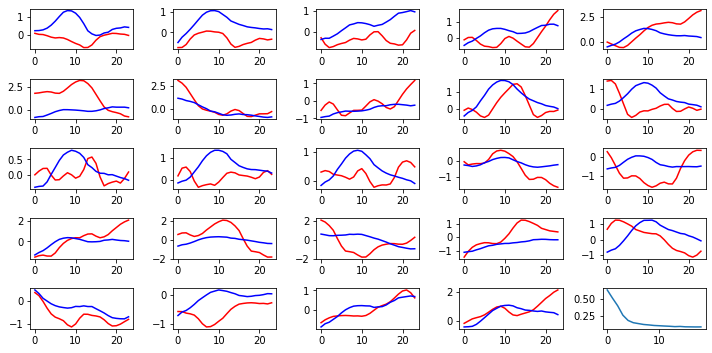

Step: 0, Train Loss: 0.07101821899414062
Step: 20, Train Loss: 0.06068488582968712
Step: 40, Train Loss: 0.061290156096220016
Step: 60, Train Loss: 0.06438475847244263
Step: 80, Train Loss: 0.11812718957662582
Step: 100, Train Loss: 0.06698235124349594
Step: 120, Train Loss: 0.07624790817499161
Step: 140, Train Loss: 0.06401535123586655
Epoch: 20, Train loss: 0.0754577228416727
acskill_socre:17.940300692362484, rmse_score:20.724328155350673
Epoch: 20, Valid Score: -2.7840274629881883


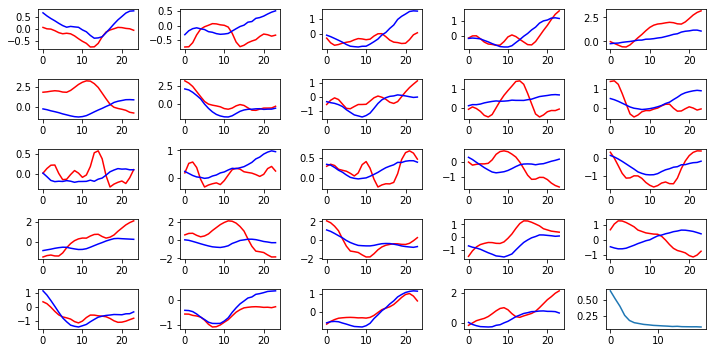

Step: 0, Train Loss: 0.05186565965414047
Step: 20, Train Loss: 0.09790052473545074
Step: 40, Train Loss: 0.05042893812060356
Step: 60, Train Loss: 0.069123774766922
Step: 80, Train Loss: 0.06595447659492493
Step: 100, Train Loss: 0.05771368741989136
Step: 120, Train Loss: 0.06109539419412613
Step: 140, Train Loss: 0.09222152084112167
Epoch: 21, Train loss: 0.07238302946294824
acskill_socre:20.066922779291165, rmse_score:20.56665098114133
Epoch: 21, Valid Score: -0.4997282018501643
Model saved successfully


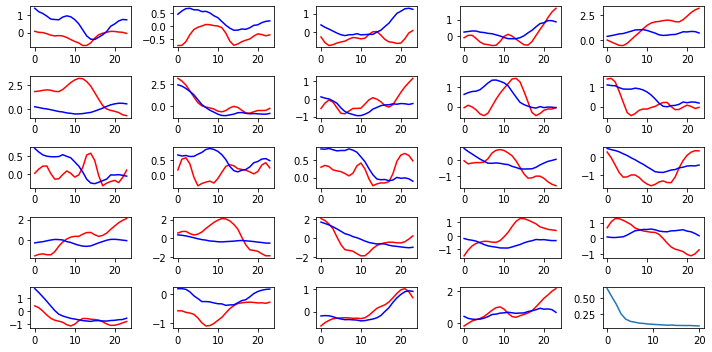

Step: 0, Train Loss: 0.072564035654068
Step: 20, Train Loss: 0.06804946064949036
Step: 40, Train Loss: 0.06308106333017349
Step: 60, Train Loss: 0.04655488580465317
Step: 80, Train Loss: 0.06388656795024872
Step: 100, Train Loss: 0.05871778726577759
Step: 120, Train Loss: 0.06898300349712372
Step: 140, Train Loss: 0.08274295926094055
Epoch: 22, Train loss: 0.06973307378181856
acskill_socre:16.82910366593904, rmse_score:20.663852013976175
Epoch: 22, Valid Score: -3.8347483480371345


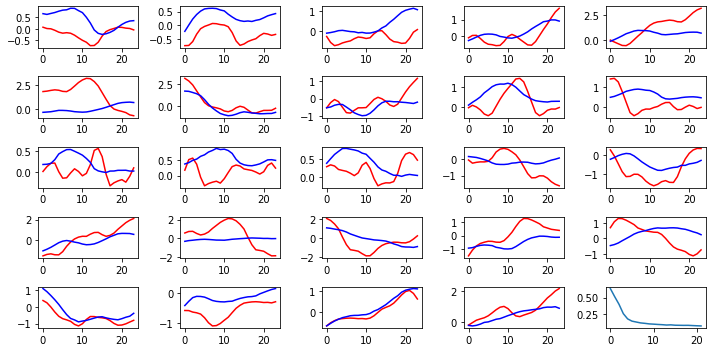

Step: 0, Train Loss: 0.0576469823718071
Step: 20, Train Loss: 0.049747101962566376
Step: 40, Train Loss: 0.08552509546279907
Step: 60, Train Loss: 0.07697369158267975
Step: 80, Train Loss: 0.0595211386680603
Step: 100, Train Loss: 0.06107274815440178
Step: 120, Train Loss: 0.11287209391593933
Step: 140, Train Loss: 0.058919280767440796
Epoch: 23, Train loss: 0.07199558962697852
acskill_socre:19.04836594161079, rmse_score:21.315800521350084
Epoch: 23, Valid Score: -2.2674345797392945


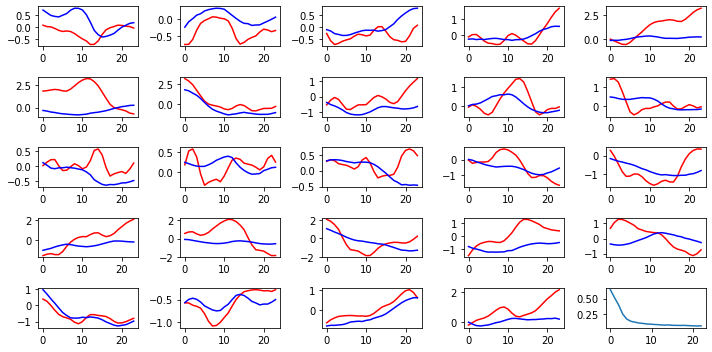

Step: 0, Train Loss: 0.04789608716964722
Step: 20, Train Loss: 0.12778572738170624
Step: 40, Train Loss: 0.042713090777397156
Step: 60, Train Loss: 0.04603924602270126
Step: 80, Train Loss: 0.08343365043401718
Step: 100, Train Loss: 0.04621383547782898
Step: 120, Train Loss: 0.060659684240818024
Step: 140, Train Loss: 0.054861586540937424
Epoch: 24, Train loss: 0.0682743082256758
acskill_socre:17.25235556044957, rmse_score:19.96557472200573
Epoch: 24, Valid Score: -2.713219161556161


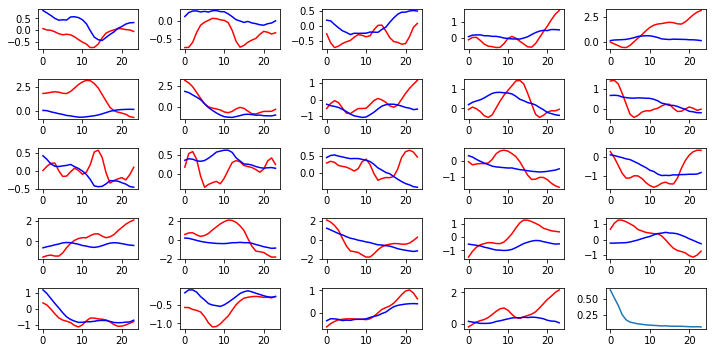

Step: 0, Train Loss: 0.047588374465703964
Step: 20, Train Loss: 0.08700300753116608
Step: 40, Train Loss: 0.07733480632305145
Step: 60, Train Loss: 0.09508451074361801
Step: 80, Train Loss: 0.04297909885644913
Step: 100, Train Loss: 0.07458826899528503
Step: 120, Train Loss: 0.08616980910301208
Step: 140, Train Loss: 0.052893929183483124
Epoch: 25, Train loss: 0.06778501693720687
acskill_socre:18.49397964498653, rmse_score:20.127119662604997
Epoch: 25, Valid Score: -1.6331400176184658


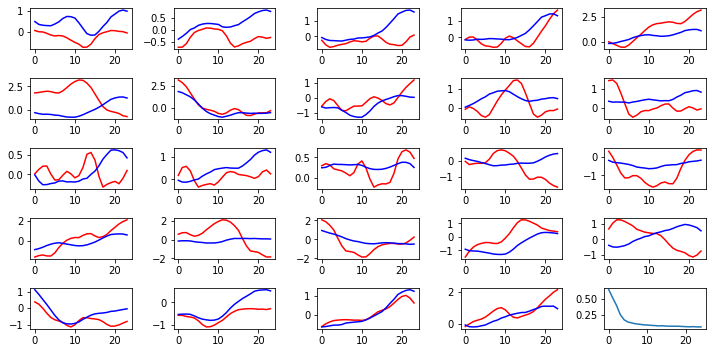

Step: 0, Train Loss: 0.05178365111351013
Step: 20, Train Loss: 0.05321384221315384
Step: 40, Train Loss: 0.07785194367170334
Step: 60, Train Loss: 0.04792225360870361
Step: 80, Train Loss: 0.05717608332633972
Step: 100, Train Loss: 0.05249371379613876
Step: 120, Train Loss: 0.05983329936861992
Step: 140, Train Loss: 0.05368887633085251
Epoch: 26, Train loss: 0.06601261967563465
acskill_socre:19.36458024277957, rmse_score:20.12352807105769
Epoch: 26, Valid Score: -0.7589478282781208


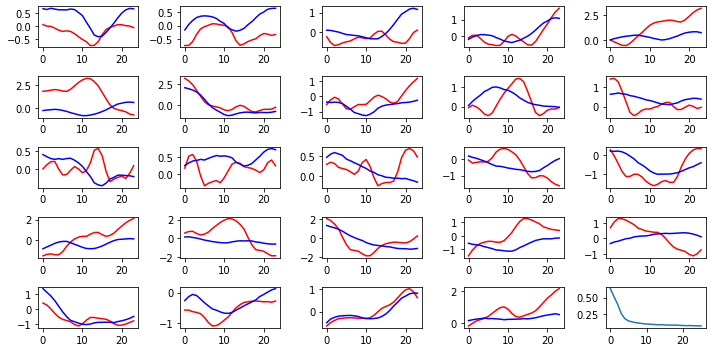

Step: 0, Train Loss: 0.051210831850767136
Step: 20, Train Loss: 0.06882283091545105
Step: 40, Train Loss: 0.05342043563723564
Step: 60, Train Loss: 0.059053774923086166
Step: 80, Train Loss: 0.0863821804523468
Step: 100, Train Loss: 0.1035134419798851
Step: 120, Train Loss: 0.06629128754138947
Step: 140, Train Loss: 0.11883383244276047
Epoch: 27, Train loss: 0.06833150735354587
acskill_socre:17.208610108081533, rmse_score:21.19677161815125
Epoch: 27, Valid Score: -3.988161510069716


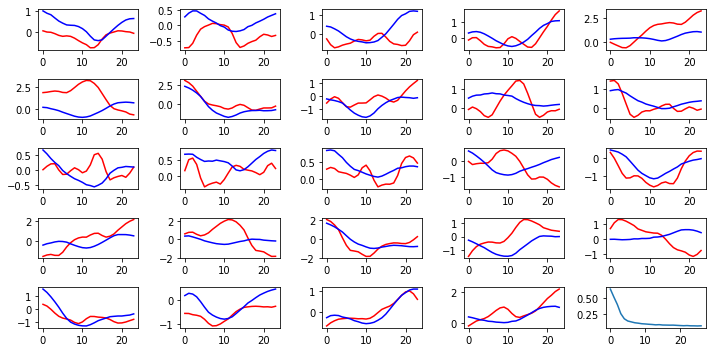

Step: 0, Train Loss: 0.06769932806491852
Step: 20, Train Loss: 0.05237609148025513
Step: 40, Train Loss: 0.08891773223876953
Step: 60, Train Loss: 0.0505872443318367
Step: 80, Train Loss: 0.03985331580042839
Step: 100, Train Loss: 0.07771749794483185
Step: 120, Train Loss: 0.058110468089580536
Step: 140, Train Loss: 0.051148708909749985
Epoch: 28, Train loss: 0.0657945748622695
acskill_socre:19.151880927774577, rmse_score:20.635977227276925
Epoch: 28, Valid Score: -1.4840962995023474


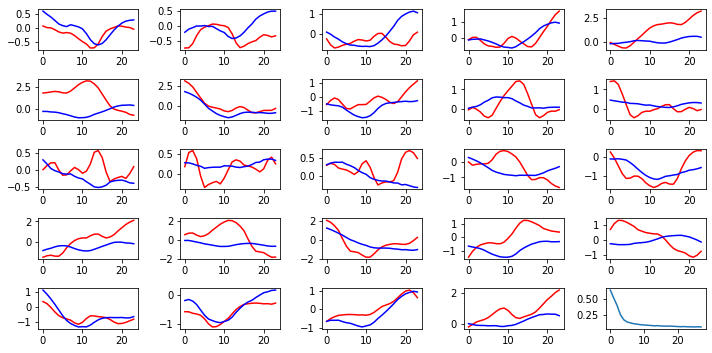

Step: 0, Train Loss: 0.03491443395614624
Step: 20, Train Loss: 0.07103876024484634
Step: 40, Train Loss: 0.06260034441947937
Step: 60, Train Loss: 0.04475460574030876
Step: 80, Train Loss: 0.06488629430532455
Step: 100, Train Loss: 0.06675154715776443
Step: 120, Train Loss: 0.13670974969863892
Step: 140, Train Loss: 0.051750510931015015
Epoch: 29, Train loss: 0.0630204513260763
acskill_socre:14.616724008104715, rmse_score:20.981967857404985
Epoch: 29, Valid Score: -6.3652438493002705


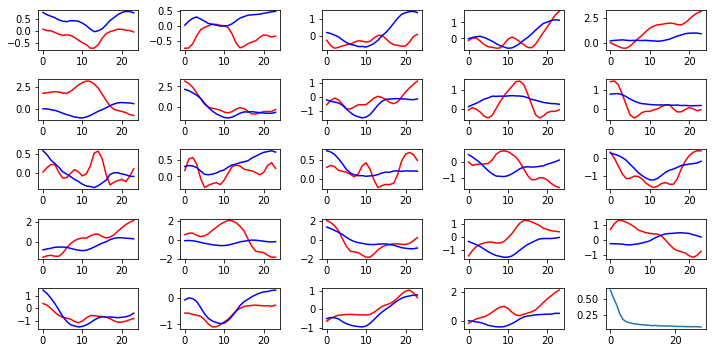

Step: 0, Train Loss: 0.09402838349342346
Step: 20, Train Loss: 0.06117607653141022
Step: 40, Train Loss: 0.056441035121679306
Step: 60, Train Loss: 0.05307958647608757
Step: 80, Train Loss: 0.046596359461545944
Step: 100, Train Loss: 0.04828415438532829
Step: 120, Train Loss: 0.05224775895476341
Step: 140, Train Loss: 0.06777439266443253
Epoch: 30, Train loss: 0.06514227954185989
acskill_socre:18.6317123749443, rmse_score:20.076981174096698
Epoch: 30, Valid Score: -1.445268799152398


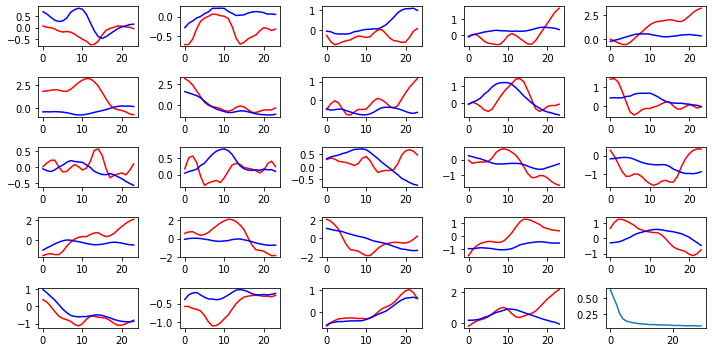

Step: 0, Train Loss: 0.05983459949493408
Step: 20, Train Loss: 0.0446644052863121
Step: 40, Train Loss: 0.040783051401376724
Step: 60, Train Loss: 0.053019218146800995
Step: 80, Train Loss: 0.08495645225048065
Step: 100, Train Loss: 0.06236739084124565
Step: 120, Train Loss: 0.048179298639297485
Step: 140, Train Loss: 0.057582929730415344
Epoch: 31, Train loss: 0.06380726657297513
acskill_socre:17.255411604245403, rmse_score:21.472499926627844
Epoch: 31, Valid Score: -4.217088322382441


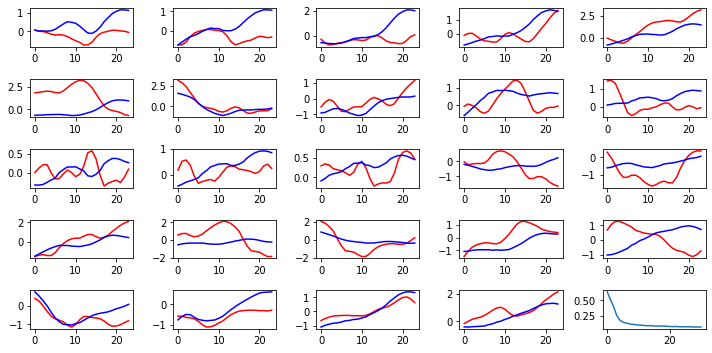

Step: 0, Train Loss: 0.04894218593835831
Step: 20, Train Loss: 0.047011516988277435
Step: 40, Train Loss: 0.05807080864906311
Step: 60, Train Loss: 0.08686719834804535
Step: 80, Train Loss: 0.06665387749671936
Step: 100, Train Loss: 0.04388522729277611
Step: 120, Train Loss: 0.03798607364296913
Step: 140, Train Loss: 0.10050252079963684
Epoch: 32, Train loss: 0.061396381447780625
acskill_socre:18.158170227764632, rmse_score:20.501429036144668
Epoch: 32, Valid Score: -2.3432588083800354


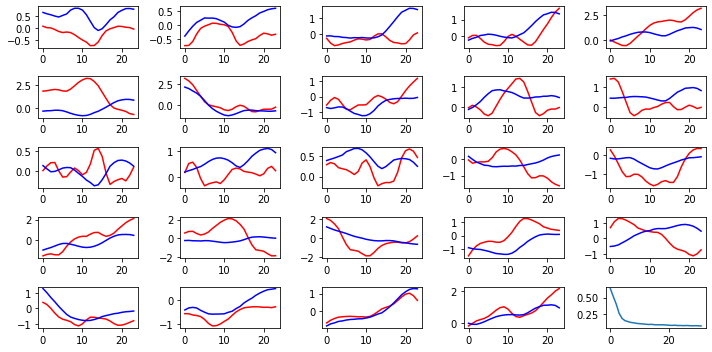

Step: 0, Train Loss: 0.051113586872816086
Step: 20, Train Loss: 0.04894791170954704
Step: 40, Train Loss: 0.05534385144710541
Step: 60, Train Loss: 0.062197357416152954
Step: 80, Train Loss: 0.04335739463567734
Step: 100, Train Loss: 0.038492415100336075
Step: 120, Train Loss: 0.07161504030227661
Step: 140, Train Loss: 0.06492772698402405
Epoch: 33, Train loss: 0.0572966579092692
acskill_socre:15.713214248117673, rmse_score:21.49248723139613
Epoch: 33, Valid Score: -5.779272983278457


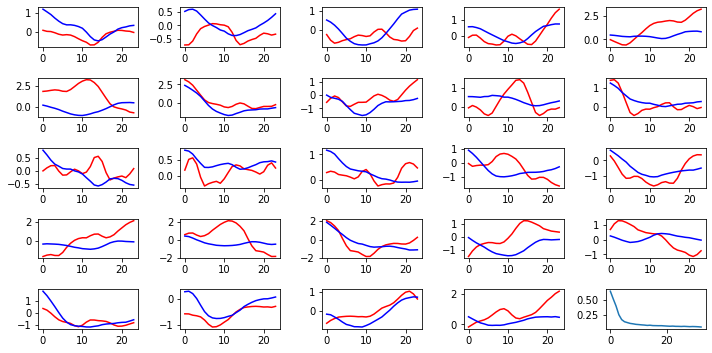

Step: 0, Train Loss: 0.05927329510450363
Step: 20, Train Loss: 0.09492932260036469
Step: 40, Train Loss: 0.08302383124828339
Step: 60, Train Loss: 0.04599515721201897
Step: 80, Train Loss: 0.0529814213514328
Step: 100, Train Loss: 0.09574685990810394
Step: 120, Train Loss: 0.04453855752944946
Step: 140, Train Loss: 0.03405541926622391
Epoch: 34, Train loss: 0.06298129365154326
acskill_socre:16.171095141428793, rmse_score:20.735566261052963
Epoch: 34, Valid Score: -4.564471119624169


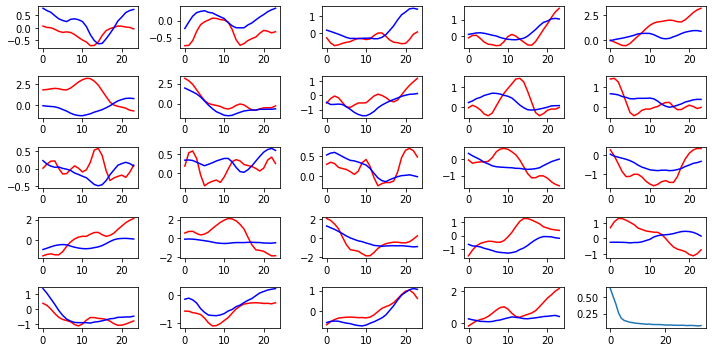

Step: 0, Train Loss: 0.08757422864437103
Step: 20, Train Loss: 0.045831382274627686
Step: 40, Train Loss: 0.033877722918987274
Step: 60, Train Loss: 0.05486534163355827
Step: 80, Train Loss: 0.06354862451553345
Step: 100, Train Loss: 0.06573337316513062
Step: 120, Train Loss: 0.049280475825071335
Step: 140, Train Loss: 0.05090826004743576
Epoch: 35, Train loss: 0.059417379611771404
acskill_socre:18.447761029448312, rmse_score:19.794890001504548
Epoch: 35, Valid Score: -1.347128972056236


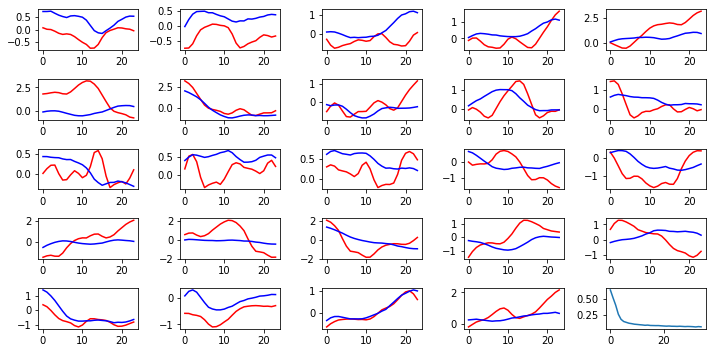

Step: 0, Train Loss: 0.07599896192550659
Step: 20, Train Loss: 0.06184535473585129
Step: 40, Train Loss: 0.04939094930887222
Step: 60, Train Loss: 0.05313251167535782
Step: 80, Train Loss: 0.042856618762016296
Step: 100, Train Loss: 0.05804535001516342
Step: 120, Train Loss: 0.10172285884618759
Step: 140, Train Loss: 0.05491657182574272
Epoch: 36, Train loss: 0.059652660246172995
acskill_socre:19.987335846856904, rmse_score:19.906478870538187
Epoch: 36, Valid Score: 0.08085697631871724
Model saved successfully


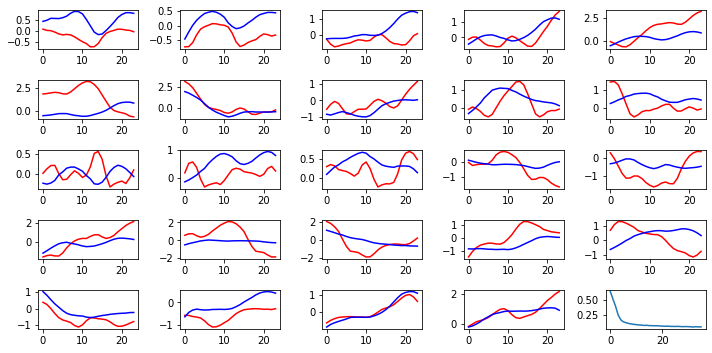

Step: 0, Train Loss: 0.03551943600177765
Step: 20, Train Loss: 0.03803769871592522
Step: 40, Train Loss: 0.05829840153455734
Step: 60, Train Loss: 0.06581699103116989
Step: 80, Train Loss: 0.04174317046999931
Step: 100, Train Loss: 0.05110956355929375
Step: 120, Train Loss: 0.05581134557723999
Step: 140, Train Loss: 0.06932461261749268
Epoch: 37, Train loss: 0.05651862671828433
acskill_socre:17.831925627444026, rmse_score:19.9092372688595
Epoch: 37, Valid Score: -2.0773116414154735


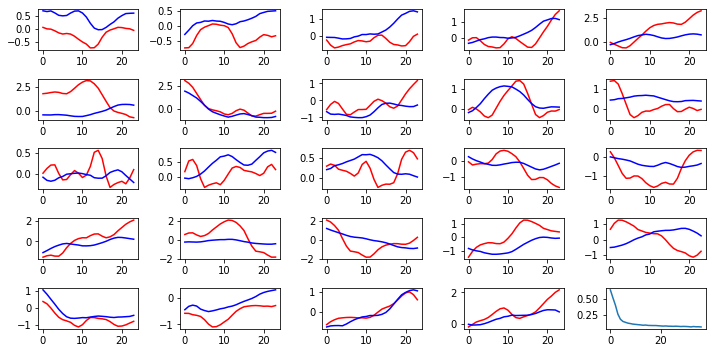

Step: 0, Train Loss: 0.059414010494947433
Step: 20, Train Loss: 0.0753587931394577
Step: 40, Train Loss: 0.07003501057624817
Step: 60, Train Loss: 0.0460362546145916
Step: 80, Train Loss: 0.043993573635816574
Step: 100, Train Loss: 0.03438547998666763
Step: 120, Train Loss: 0.03566597402095795
Step: 140, Train Loss: 0.043240129947662354
Epoch: 38, Train loss: 0.057078968759064805
acskill_socre:17.616954621190576, rmse_score:20.364807500537506
Epoch: 38, Valid Score: -2.7478528793469295


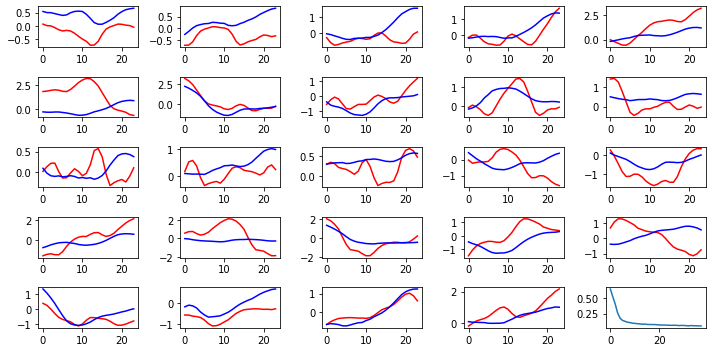

Step: 0, Train Loss: 0.052964188158512115
Step: 20, Train Loss: 0.07234957814216614
Step: 40, Train Loss: 0.05474039167165756
Step: 60, Train Loss: 0.05224955081939697
Step: 80, Train Loss: 0.060125719755887985
Step: 100, Train Loss: 0.038925401866436005
Step: 120, Train Loss: 0.1078684851527214
Step: 140, Train Loss: 0.06276586651802063
Epoch: 39, Train loss: 0.05671709423808202
acskill_socre:16.51129574918655, rmse_score:20.319457021199256
Epoch: 39, Valid Score: -3.808161272012704


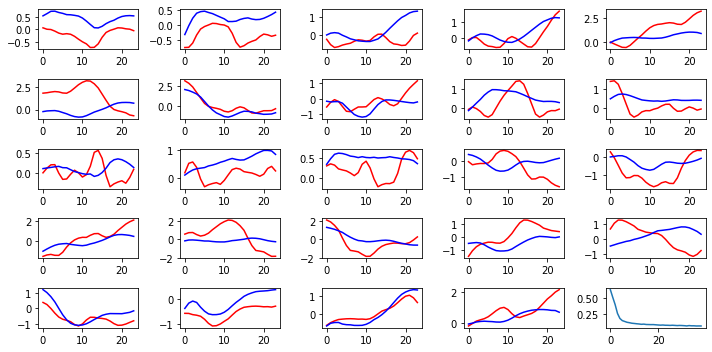

Step: 0, Train Loss: 0.042130082845687866
Step: 20, Train Loss: 0.04455433413386345
Step: 40, Train Loss: 0.036747757345438004
Step: 60, Train Loss: 0.09023984521627426
Step: 80, Train Loss: 0.05070382356643677
Step: 100, Train Loss: 0.05134633928537369
Step: 120, Train Loss: 0.05522630736231804
Step: 140, Train Loss: 0.05095500871539116
Epoch: 40, Train loss: 0.05512447606721153
acskill_socre:18.048411603971495, rmse_score:21.022243328475234
Epoch: 40, Valid Score: -2.9738317245037393


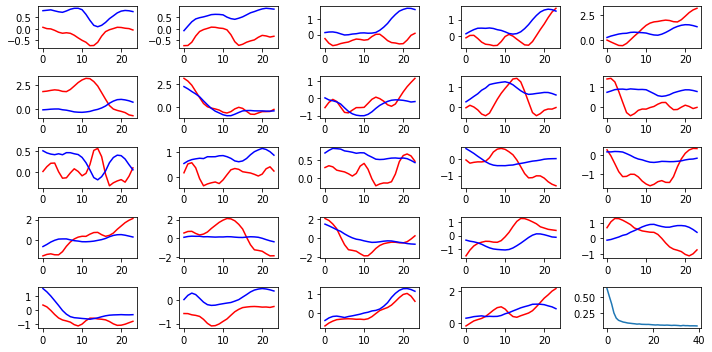

Step: 0, Train Loss: 0.04445646330714226
Step: 20, Train Loss: 0.054794639348983765
Step: 40, Train Loss: 0.06836487352848053
Step: 60, Train Loss: 0.09175296127796173
Step: 80, Train Loss: 0.058061279356479645
Step: 100, Train Loss: 0.031871404498815536
Step: 120, Train Loss: 0.07596519589424133
Step: 140, Train Loss: 0.0515274852514267
Epoch: 41, Train loss: 0.05415614141942295
acskill_socre:20.897337248050825, rmse_score:19.90733812407708
Epoch: 41, Valid Score: 0.989999123973746
Model saved successfully


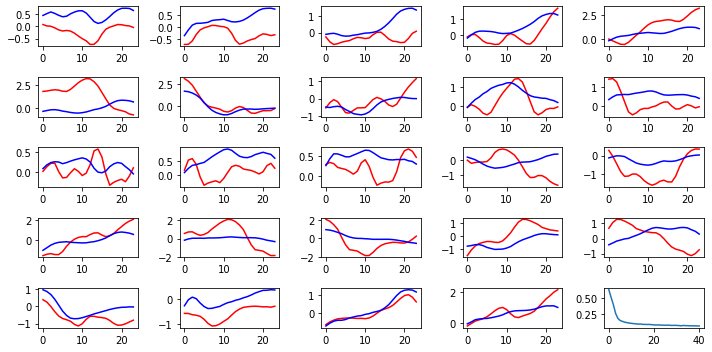

Step: 0, Train Loss: 0.06969573348760605
Step: 20, Train Loss: 0.038202475756406784
Step: 40, Train Loss: 0.07114063203334808
Step: 60, Train Loss: 0.04426366090774536
Step: 80, Train Loss: 0.049304913729429245
Step: 100, Train Loss: 0.05609460175037384
Step: 120, Train Loss: 0.040588781237602234
Step: 140, Train Loss: 0.06005832180380821
Epoch: 42, Train loss: 0.05563878859967401
acskill_socre:19.69610784489058, rmse_score:20.35610251972865
Epoch: 42, Valid Score: -0.659994674838071


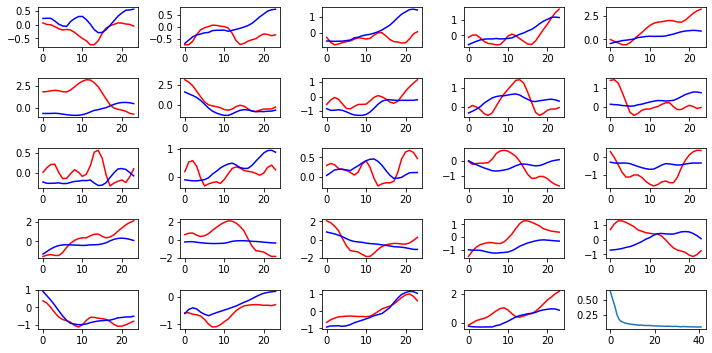

Step: 0, Train Loss: 0.0466402992606163
Step: 20, Train Loss: 0.04679501801729202
Step: 40, Train Loss: 0.037075210362672806
Step: 60, Train Loss: 0.07859645783901215
Step: 80, Train Loss: 0.09724631160497665
Step: 100, Train Loss: 0.030537348240613937
Step: 120, Train Loss: 0.044769346714019775
Step: 140, Train Loss: 0.04376488924026489
Epoch: 43, Train loss: 0.05275089869097079
acskill_socre:20.342191428283492, rmse_score:20.732352172699226
Epoch: 43, Valid Score: -0.39016074441573423


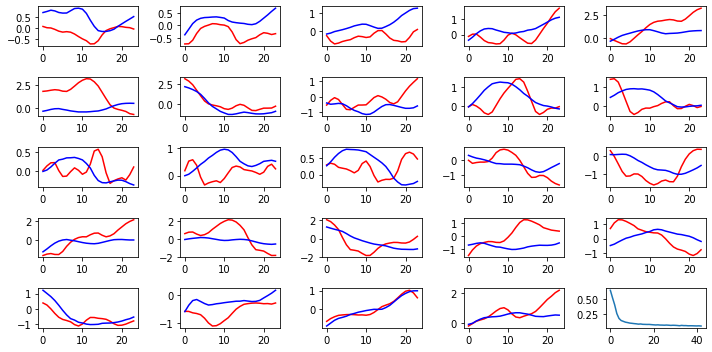

Step: 0, Train Loss: 0.057039692997932434
Step: 20, Train Loss: 0.040168821811676025
Step: 40, Train Loss: 0.04403351992368698
Step: 60, Train Loss: 0.029427677392959595
Step: 80, Train Loss: 0.0614863745868206
Step: 100, Train Loss: 0.040041763335466385
Step: 120, Train Loss: 0.05399863049387932
Step: 140, Train Loss: 0.06813612580299377
Epoch: 44, Train loss: 0.05471351770811701
acskill_socre:20.09970703914468, rmse_score:20.147053197066125
Epoch: 44, Valid Score: -0.04734615792144581


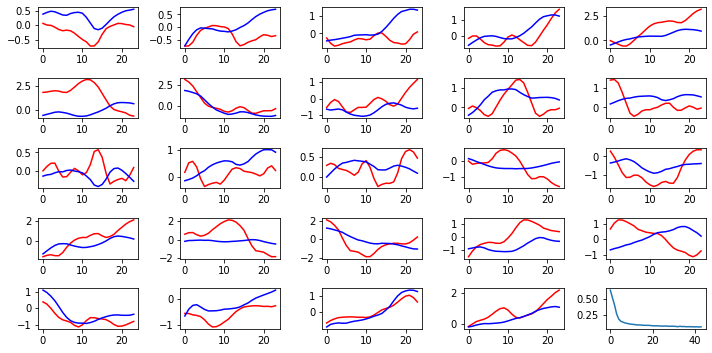

Step: 0, Train Loss: 0.056760869920253754
Step: 20, Train Loss: 0.07369955629110336
Step: 40, Train Loss: 0.04098935425281525
Step: 60, Train Loss: 0.03571891784667969
Step: 80, Train Loss: 0.07738257199525833
Step: 100, Train Loss: 0.09244238585233688
Step: 120, Train Loss: 0.037781789898872375
Step: 140, Train Loss: 0.12388815730810165
Epoch: 45, Train loss: 0.05118615085845941
acskill_socre:17.983344783735618, rmse_score:19.29697810056283
Epoch: 45, Valid Score: -1.313633316827211


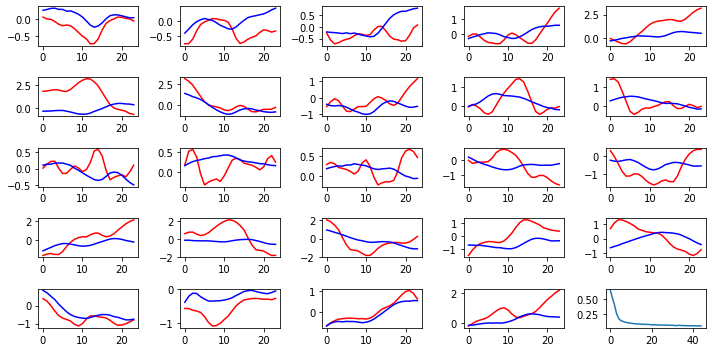

Step: 0, Train Loss: 0.05562221631407738
Step: 20, Train Loss: 0.09139503538608551
Step: 40, Train Loss: 0.043361395597457886
Step: 60, Train Loss: 0.0459168367087841
Step: 80, Train Loss: 0.03781570494174957
Step: 100, Train Loss: 0.08754020929336548
Step: 120, Train Loss: 0.0892244428396225
Step: 140, Train Loss: 0.0815688818693161
Epoch: 46, Train loss: 0.05626798345873209
acskill_socre:19.358382214669383, rmse_score:19.77920318418441
Epoch: 46, Valid Score: -0.42082096951502734


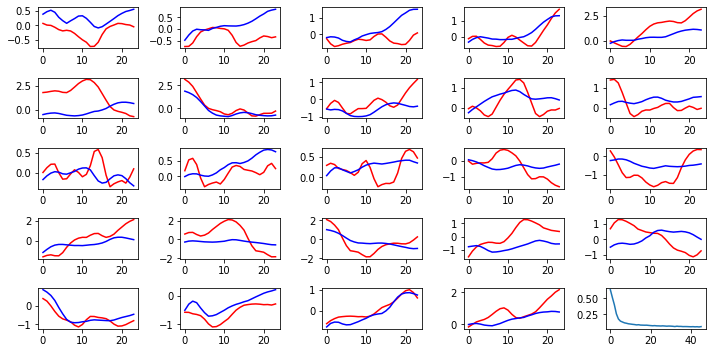

Step: 0, Train Loss: 0.09984507411718369
Step: 20, Train Loss: 0.07065977901220322
Step: 40, Train Loss: 0.04002586007118225
Step: 60, Train Loss: 0.032742612063884735
Step: 80, Train Loss: 0.09253337234258652
Step: 100, Train Loss: 0.0408814512193203
Step: 120, Train Loss: 0.05050972104072571
Step: 140, Train Loss: 0.03654683381319046
Epoch: 47, Train loss: 0.05442198656805574
acskill_socre:19.079917734626985, rmse_score:20.372451012271892
Epoch: 47, Valid Score: -1.2925332776449068


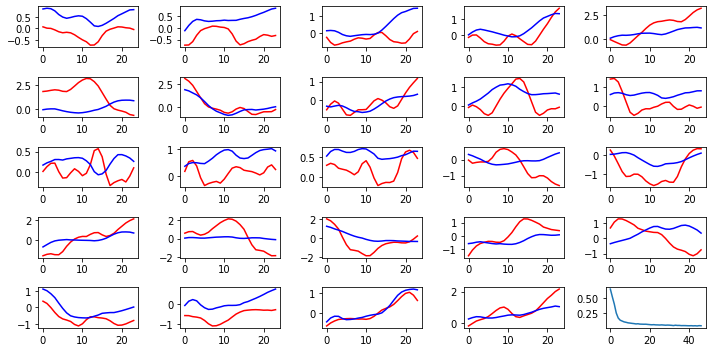

Step: 0, Train Loss: 0.038521744310855865
Step: 20, Train Loss: 0.03879895433783531
Step: 40, Train Loss: 0.03880772739648819
Step: 60, Train Loss: 0.04698675498366356
Step: 80, Train Loss: 0.10815936326980591
Step: 100, Train Loss: 0.08604766428470612
Step: 120, Train Loss: 0.07650628685951233
Step: 140, Train Loss: 0.039586689323186874
Epoch: 48, Train loss: 0.05045805759217641
acskill_socre:18.5566743451505, rmse_score:20.14225393672618
Epoch: 48, Valid Score: -1.58557959157568


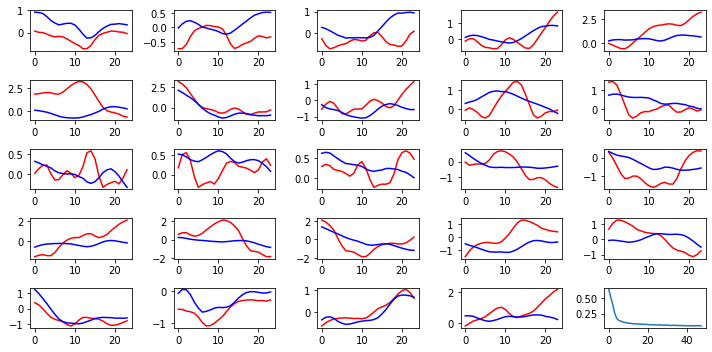

Step: 0, Train Loss: 0.03474075719714165
Step: 20, Train Loss: 0.04683829843997955
Step: 40, Train Loss: 0.05136167258024216
Step: 60, Train Loss: 0.028816495090723038
Step: 80, Train Loss: 0.08897025883197784
Step: 100, Train Loss: 0.03759053349494934
Step: 120, Train Loss: 0.03697691485285759
Step: 140, Train Loss: 0.03837672621011734
Epoch: 49, Train loss: 0.05207860784936849
acskill_socre:17.307164769465764, rmse_score:20.281495377313448
Epoch: 49, Valid Score: -2.9743306078476834


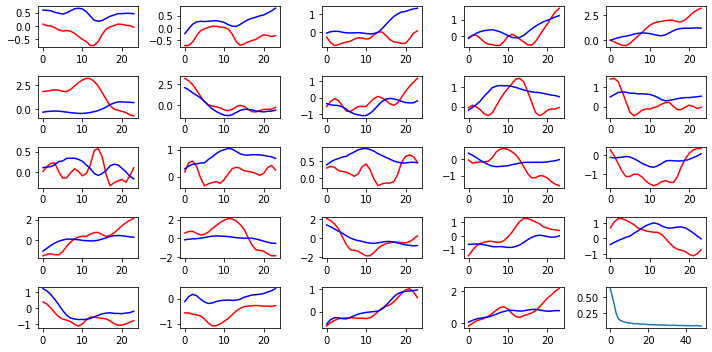

Step: 0, Train Loss: 0.04326101392507553
Step: 20, Train Loss: 0.045126087963581085
Step: 40, Train Loss: 0.038097769021987915
Step: 60, Train Loss: 0.05091409012675285
Step: 80, Train Loss: 0.09574123471975327
Step: 100, Train Loss: 0.02815582975745201
Step: 120, Train Loss: 0.06661955267190933
Step: 140, Train Loss: 0.056130439043045044
Epoch: 50, Train loss: 0.051696245443739304
acskill_socre:19.373806595259964, rmse_score:19.61747745065256
Epoch: 50, Valid Score: -0.24367085539259747


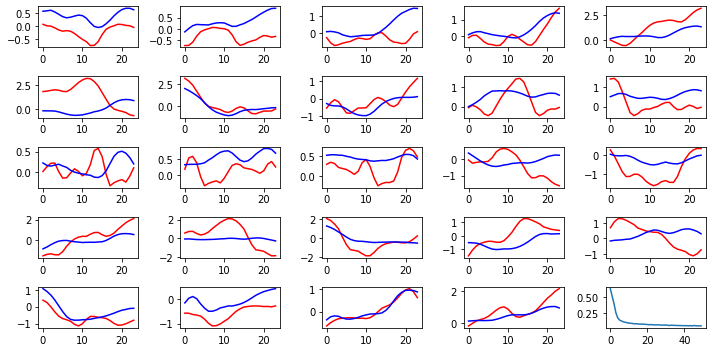

In [20]:
train(num_epochs=50)

In [ ]:
model.load_state_dict(torch.load('models/basemodel_epoch_5.pt'))

In [15]:
test_path = './tcdata/enso_round1_test_20210201/'

### load test data
files = os.listdir(test_path)
test_feas_dict = {}
for file in files:
    test_feas_dict[file] = np.load(test_path + file)

In [16]:
### 2. predict
test_predicts_dict = {}
for file_name, val in test_feas_dict.items():
    SST = np.expand_dims(val[:,:,:,0],axis=0)
    T300 = np.expand_dims(val[:,:,:,1],axis=0)
    Ua = np.expand_dims(val[:,:,:,2],axis=0)
    Va = np.expand_dims(val[:,:,:,3],axis=0)
    
    SST = np.nan_to_num(SST) # trans nan to 0
    T300 = np.nan_to_num(T300)
    Ua = np.nan_to_num(Ua)
    Va = np.nan_to_num(Va)
    
    data_list = [SST,T300,Ua,Va]
    SST,T300,Ua,Va = fit_data(data_list, fit=False)

    SST = torch.tensor(SST).to(device).float()
    T300 = torch.tensor(T300).to(device).float()
    Ua = torch.tensor(Ua).to(device).float()
    Va = torch.tensor(Va).to(device).float()
    
    result = model(SST, T300, Ua, Va).view(-1).detach().cpu().numpy()
    test_predicts_dict[file_name] = result

(20736, 4)


In [17]:
### 3. save results
if os.path.exists('./result/'):  
    shutil.rmtree('./result/', ignore_errors=True)  
os.makedirs('./result/')
for file_name, val in test_predicts_dict.items(): 
    np.save('./result/' + file_name, val)

In [18]:
def make_zip(res_dir='./result', output_dir='result.zip'):  
    z = zipfile.ZipFile(output_dir, 'w')  
    for file in os.listdir(res_dir):  
        if '.npy' not in file:
            continue
        z.write(res_dir + os.sep + file)  
    z.close()

In [19]:
make_zip()